In [ ]:
%pip install mlflow

In [ ]:
%pip install shap


# Import Data from DB

In [ ]:
# 載入資料
df = spark.table("hive_metastore.default.breast_cancer_dataset_csv")

# 顯示前五行資料，確認結構
df.show(5)

# 查看目標變量的分布
df.groupBy("diagnosis").count().show()


+--------+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+
|      id|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|
+--------+---------+-----------+------------+---

In [ ]:
df.printSchema()


root
 |-- diagnosis: string (nullable = true)
 |-- radius_mean: string (nullable = true)
 |-- texture_mean: string (nullable = true)
 |-- perimeter_mean: string (nullable = true)
 |-- area_mean: string (nullable = true)
 |-- smoothness_mean: string (nullable = true)
 |-- compactness_mean: string (nullable = true)
 |-- concavity_mean: string (nullable = true)
 |-- concave points_mean: string (nullable = true)
 |-- symmetry_mean: string (nullable = true)
 |-- fractal_dimension_mean: string (nullable = true)
 |-- radius_se: string (nullable = true)
 |-- texture_se: string (nullable = true)
 |-- perimeter_se: string (nullable = true)
 |-- area_se: string (nullable = true)
 |-- smoothness_se: string (nullable = true)
 |-- compactness_se: string (nullable = true)
 |-- concavity_se: string (nullable = true)
 |-- concave points_se: string (nullable = true)
 |-- symmetry_se: string (nullable = true)
 |-- fractal_dimension_se: string (nullable = true)
 |-- radius_worst: string (nullable = true)


# MLflow tracking ML model

In [ ]:
import mlflow
from mlflow import spark
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col, when
from pyspark.sql import SparkSession

# Spark session
spark = SparkSession.builder.getOrCreate()

# 資料準備
df = spark.table("hive_metastore.default.breast_cancer_dataset_csv")

# Drop unwanted columns
df = df.drop("id")

# Convert all feature columns to numeric type (Double)
for column_name in df.columns:
    if column_name != "diagnosis":
        df = df.withColumn(column_name, col(column_name).cast("double"))

# Convert "diagnosis" from string to numeric
label_indexer = StringIndexer(inputCol="diagnosis", outputCol="label")

# Define feature columns (excluding ID and diagnosis columns)
feature_cols = [col_name for col_name in df.columns if col_name != "diagnosis" and col_name != "label"]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

classifier = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)

pipeline = Pipeline(stages=[label_indexer, assembler, classifier])

# Split the data into training and test sets
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# 使用 MLflow 跟踪
with mlflow.start_run():
    # 訓練模型
    model = pipeline.fit(train_df)

    # 使用模型進行預測
    predictions = model.transform(test_df)

    # 評估模型
    evaluator = BinaryClassificationEvaluator(labelCol="label")
    roc_auc = evaluator.evaluate(predictions)

    # 使用 MLflow 記錄指標
    mlflow.log_metric("roc_auc", roc_auc)

    # 儲存模型
    mlflow.spark.save_model(model, "models/my_breast_cancer_gbt_model")


/databricks/python/lib/python3.9/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


## Same Model Multi-parameters exp

In [ ]:
# 定義一個函數來訓練和評估模型，同時記錄在MLflow
def train_evaluate_gbt(params):
    classifier = GBTClassifier(labelCol="label",
                               featuresCol="features",
                               maxIter=params['maxIter'],
                               maxDepth=params['maxDepth'],
                               maxBins=params['maxBins'])

    pipeline = Pipeline(stages=[label_indexer, assembler, classifier])

    with mlflow.start_run():
        # 訓練模型
        model = pipeline.fit(train_df)
        # 使用模型進行預測
        predictions = model.transform(test_df)
        # 評估模型
        evaluator = BinaryClassificationEvaluator(labelCol="label")
        roc_auc = evaluator.evaluate(predictions)
        # 使用 MLflow 記錄參數和指標
        mlflow.log_params(params)
        mlflow.log_metric("roc_auc", roc_auc)

# 訓練不同參數的模型
param_sets = [
    {"maxIter": 10, "maxDepth": 5, "maxBins": 32},
    {"maxIter": 15, "maxDepth": 5, "maxBins": 32},
    {"maxIter": 10, "maxDepth": 7, "maxBins": 32},
    {"maxIter": 10, "maxDepth": 5, "maxBins": 40}
]

for params in param_sets:
    train_evaluate_gbt(params)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
# 資料準備
df = spark.table("hive_metastore.default.breast_cancer_dataset_csv")

# Drop unwanted columns
df = df.drop("id")

# Split the data into training and test sets
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)
# 1. 將Spark DataFrame轉換為Pandas DataFrame
pdf = train_df.toPandas()

# 2. 分割數據
X = pdf.drop("diagnosis", axis=1)
y = pdf["diagnosis"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. 使用GradientBoostingClassifier重新訓練模型
gbm = GradientBoostingClassifier()
gbm_model = gbm.fit(X_train, y_train)


In [ ]:
from pyspark.ml.classification import RandomForestClassifier

# 定義一個函數來訓練和評估Random Forest模型，並在MLflow中跟踪
def train_evaluate_rf(params):
    classifier = RandomForestClassifier(labelCol="label",
                                        featuresCol="features",
                                        numTrees=params['numTrees'],
                                        maxDepth=params['maxDepth'],
                                        maxBins=params['maxBins'])

    pipeline = Pipeline(stages=[label_indexer, assembler, classifier])

    with mlflow.start_run():
        # 訓練模型
        model = pipeline.fit(train_df)
        # 使用模型進行預測
        predictions = model.transform(test_df)
        # 評估模型
        evaluator = BinaryClassificationEvaluator(labelCol="label")
        roc_auc = evaluator.evaluate(predictions)
        # 使用 MLflow 記錄參數和指標
        mlflow.log_param("model_type", "RandomForest")
        mlflow.log_params(params)
        mlflow.log_metric("roc_auc", roc_auc)

# 訓練不同參數的Random Forest模型
rf_param_sets = [
    {"numTrees": 50, "maxDepth": 5, "maxBins": 32},
    {"numTrees": 100, "maxDepth": 5, "maxBins": 32},
    {"numTrees": 50, "maxDepth": 7, "maxBins": 32},
    {"numTrees": 50, "maxDepth": 5, "maxBins": 40}
]

for params in rf_param_sets:
    train_evaluate_rf(params)


# SHAP Expalinable AI module

We first try GMB model

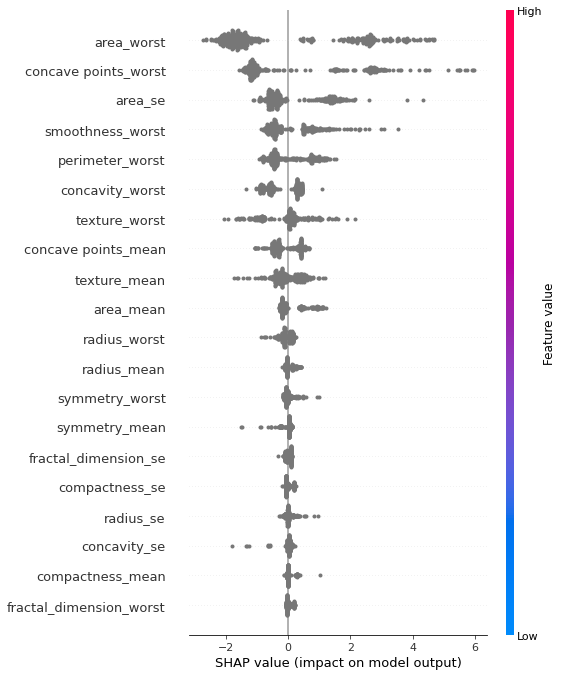

In [ ]:
import shap

# 初始化SHAP的解釋器
explainer = shap.TreeExplainer(gbm_model)

# 計算SHAP值
shap_values = explainer.shap_values(X_train)

# 繪製總體的SHAP值統計
shap.summary_plot(shap_values, X_train)


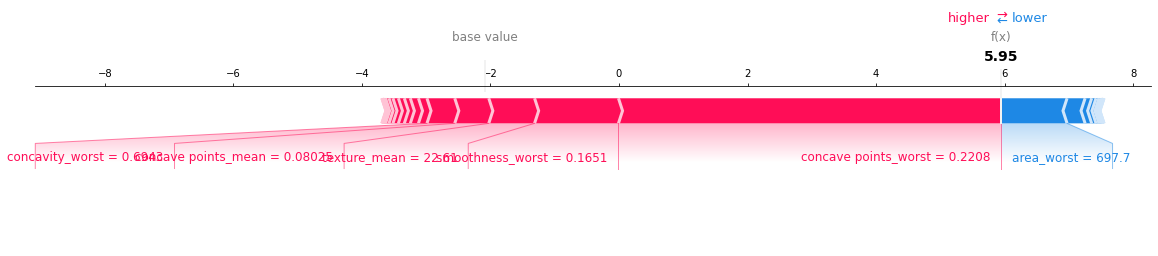

In [ ]:
shap.force_plot(explainer.expected_value[0], shap_values[10], instance, matplotlib=True)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# 資料準備
df = spark.table("hive_metastore.default.breast_cancer_dataset_csv")

# Drop unwanted columns
df = df.drop("id")

# Split the data into training and test sets
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# 1. 將Spark DataFrame轉換為Pandas DataFrame
pdf = train_df.toPandas()

# 2. 分割數據
X = pdf.drop("diagnosis", axis=1)
y = pdf["diagnosis"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. 使用RandomForestClassifier重新訓練模型，並設定所提供的模型參數
rf = RandomForestClassifier(max_depth=7, n_estimators=50, random_state=42)
rf_model = rf.fit(X_train, y_train)


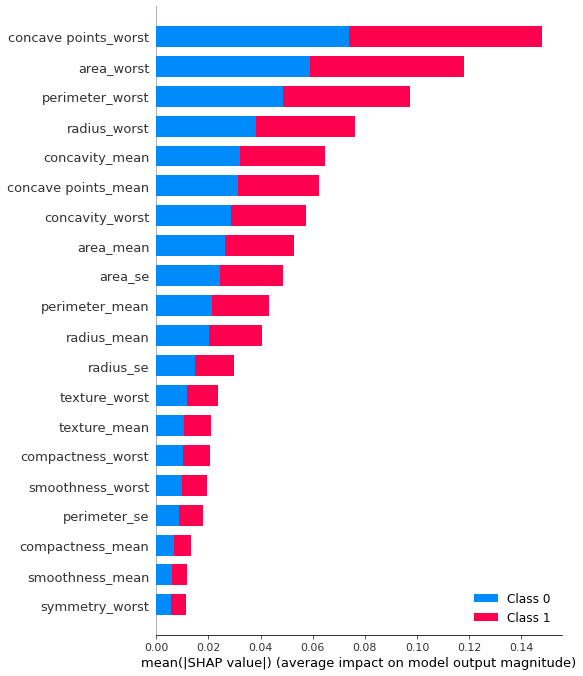

In [ ]:
import shap

# 初始化TreeExplainer
explainer = shap.TreeExplainer(rf_model)

# 計算SHAP值
shap_values = explainer.shap_values(X_train)

# SHAP全局解釋 - Summary Plot
shap.summary_plot(shap_values, X_train, plot_type="bar")


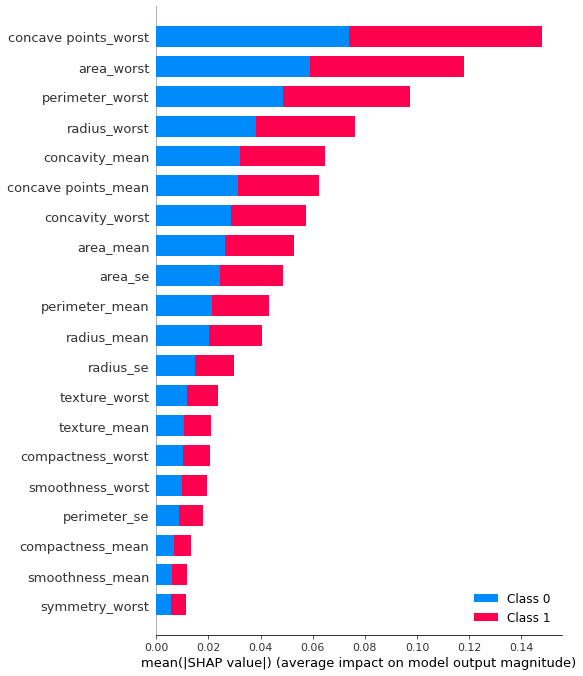

In [ ]:
import shap
import matplotlib.pyplot as plt

# 初始化TreeExplainer
explainer = shap.TreeExplainer(rf_model)

# 計算SHAP值
shap_values = explainer.shap_values(X_train)

# SHAP全局解釋 - Summary Plot
shap.summary_plot(shap_values, X_train)

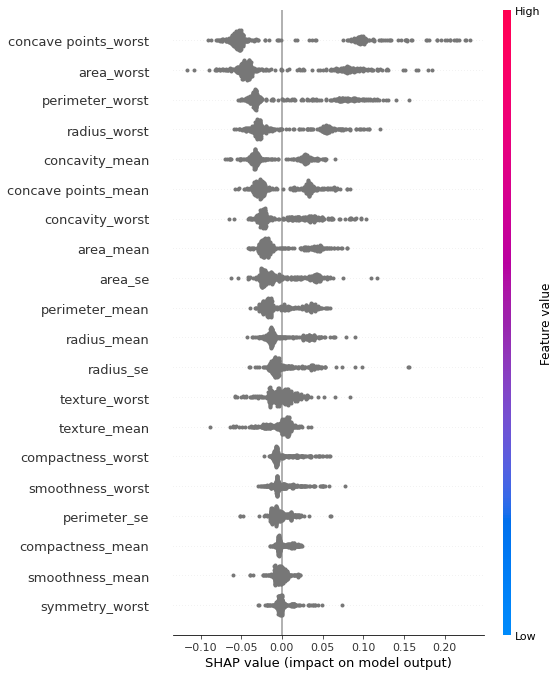

In [ ]:
# 使用TreeExplainer計算SHAP值
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_train)

# 使用summary_plot獲取全局解釋
shap.summary_plot(shap_values[1], X_train)


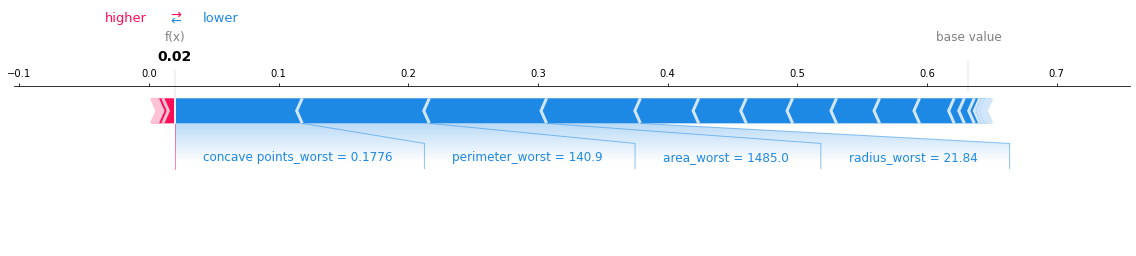

In [ ]:
# SHAP局部解釋 - 對某個特定樣本的解釋
sample_index = 0  # 選擇一個樣本的索引進行局部解釋
instance = X_train.iloc[sample_index]

# 使用matplotlib生成force plot
shap.force_plot(explainer.expected_value[0], shap_values[0][sample_index], instance, matplotlib=True)
plt.show()